In [1]:
import sympy
sympy.init_printing()
%matplotlib inline

Fourier series
=========

We can approximate a periodic function of period P to arbitrary accuracy by adding sine and cosine terms (disguised via the Euler formula in the complex exponential): 

$$ S_N(t) = \sum_{n=-N}^N c_n \exp \left( \frac{i 2\pi n t}{P}\right) $$ 

with 

$$ c_n = \frac{1}{P} \int_{t_0}^{t_0 + P} f(t) \exp \left( \frac{-i 2\pi n t}{P}\right) \mathrm{d}t $$

The following two functions attempt to match the notation above as closely as possible using sympy functions

In [2]:
i2pi = sympy.I*2*sympy.pi
exp = sympy.exp

In [3]:
def S(N):
    return sum(c(n)*exp(i2pi*n*t/P) for n in range(-N, N+1)).expand(complex=True).simplify()

In [4]:
def c(n):
    return (sympy.integrate(
               f(t)*exp((-i2pi * n * t)/P), 
               (t, t0, t0 + P))/P)

These functions work quite well for a periodic sawtooth function:

In [5]:
def f(t):
    return t

In [6]:
P = 20
t0 = -10

In [7]:
t = sympy.Symbol('t', real=True)

In [8]:
N = 6

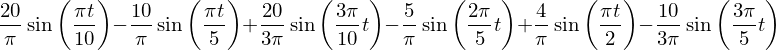

In [9]:
analytic_approx = S(N).expand()
analytic_approx

Notice that the function we defined was just $y=t$, but Fourier series always approximates periodic signals. We can see the bit we approximated repeating if we plot over a larger interval

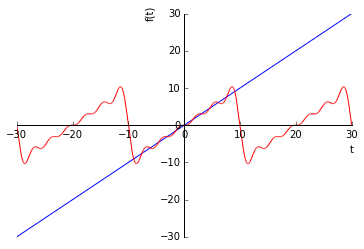

In [10]:
interval = (t, t0-P, t0+2*P)
p1 = sympy.plot(f(t), interval, show=False)
p2 = sympy.plot(analytic_approx, interval, show=False)
p2[0].line_color = 'red'
p1.extend(p2)
p1.show()

Unfortunately, this notationally elegant approach does not appear to work for `f = sympy.Heaviside`, and is also quite slow. The `sympy.mpmath` library supplies a numeric equivalent.

In [11]:
import sympy.mpmath

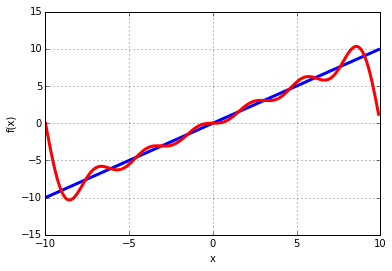

In [12]:
cs = sympy.mpmath.fourier(f, [t0, t0+P], N)

def numeric_approx(t):
    return sympy.mpmath.fourierval(cs, [t0, t0+P], t)

sympy.mpmath.plot([f, numeric_approx], [t0, t0+P])

The coefficients returned by the `sympy.mpmath.fourier` functions are for the cosine and sine terms in this alternate representation of $S_N$

$$s_N(t) = \sum_{n=0}^N \left(a_n \cos\left(\frac{2\pi nt}{P}\right) + b_n \sin\left(\frac{2\pi nt}{P}\right)\right)$$



We can see the similarity clearly by showing the expression we obtained before multiplied out and numerically evaluated

In [13]:
cs

([mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0')],
 [mpf('0.0'),
  mpf('6.366197723675814'),
  mpf('-3.183098861837907'),
  mpf('2.1220659078919377'),
  mpf('-1.5915494309189535'),
  mpf('1.2732395447351628'),
  mpf('-1.0610329539459689')])

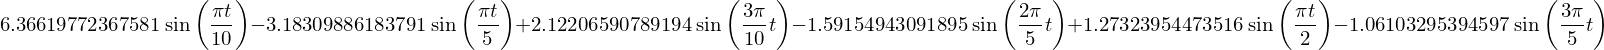

In [14]:
sympy.N(analytic_approx)

Notice that all the cosine coefficients are zero. This is true in general for odd functions.

Step function
------------
Let's now switch to the Heaviside step and draw the various sinusoids in the approximation more explicitly.

In [15]:
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

In [16]:
N = 20

In [17]:
@numpy.vectorize
def f(t):
    if t < 0:
        return 0
    else:
        return 1

In [18]:
cs = sympy.mpmath.fourier(f, [t0, t0+P], N)
cs

([mpf('0.5'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0'),
  mpf('0.0')],
 [mpf('0.0'),
  mpf('0.63675856242795037'),
  mpf('0.0002778345608862911'),
  mpf('0.21262398013873579'),
  mpf('0.00055771310594110598'),
  mpf('0.12802302327076248'),
  mpf('0.00084172518315335683'),
  mpf('0.091931640154520794'),
  mpf('0.0011320535572161288'),
  mpf('0.072015836887865267'),
  mpf('0.0014310262052054015'),
  mpf('0.059459060405769593'),
  mpf('0.0017411752581774926'),
  mpf('0.050872056499090879'),
  mpf('0.0020653060695558258'),
  mpf('0.044674904291434447'),
  mpf('0.0024065804723679999'),
  mpf('0.040032978763113902'),
  mpf('0.002768619592788056'),
  mpf('0.036465018126357898'),
  mpf('0.0031556335077388429')])

We see that all the cosine terms but the first are zero, so the first cosine coefficient represents a constant being added to the sine series.

In [19]:
constant = cs[0][0]
sinecoefficients = cs[1]

I'm constructing two dimensional arrays here which will allow my formulae to work nicely when broadcasting. I'll use the convention that the time dimension is in the columns and each sine response is in the rows.

In [20]:
tt = numpy.linspace(t0, t0 + P, 1000)
t2d = tt[numpy.newaxis]  # two dimensional time array, time in the columns

In [21]:
# two dimensional arrays for the sine coefficients and n - they vary in the rows
an = numpy.array(sinecoefficients)[:, numpy.newaxis]
n = numpy.arange(N+1)[:, numpy.newaxis]

This way I can build a whole array of sine responses automatically. 

In [22]:
sines = an*numpy.sin(2*numpy.pi*n*t2d/P)

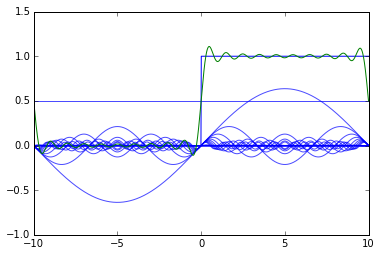

In [23]:
plt.plot(tt, f(tt))
plt.plot(tt, sines.T, color='blue', alpha=0.7)
plt.axhline(constant, color='blue', alpha=0.7)
plt.plot(tt, sum(sines) + constant)

We can see that the sum of the sines approximates the step function.

Step response via Frequency response
=================

Let's calculate the step response of a second order system in a new way by using the frequency response of the transfer function and the Fourier series of the step input.

In [24]:
s = sympy.Symbol('s')

In [25]:
tau = 1
zeta = sympy.Rational(1, 2)

In [26]:
G = 1/(tau**2*s**2 + 2*tau*zeta*s + 1)
g = sympy.inverse_laplace_transform(G/s, s, t)

This next cell takes a long time to complete, but it is the only way I have found to get a workable numeric list to plot the output. Ideally, I would have liked to use `sympy.lambdify`, but it chokes the evaluation of some of these values.

In [27]:
%%time
gtvalues = [complex(g.subs({t: thist})).real for thist in tt]

CPU times: user 48.4 s, sys: 318 ms, total: 48.7 s
Wall time: 49.4 s


We can see the familiar second order step response:

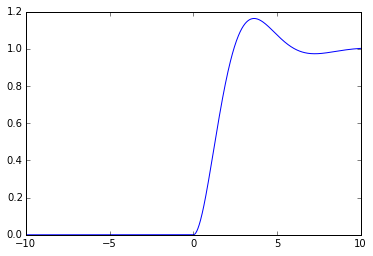

In [28]:
plt.plot(tt, gtvalues)

Now, let's try to get the same answer by exploiting the frequency response of the transfer function. First, we need a function which can evaluate the transfer function at particular values and return a numeric result. I use the extra argument to make the function able to work with numpy arrays

In [29]:
Geval = sympy.lambdify(s, G, 'numpy')

Now, we need to build an array for the frequencies of the Fourier series. Remember we had terms of the form $\sin\left(\frac{2\pi n t}{P}\right) = \sin(\omega t)$ in the Fourier series.

In [30]:
omega = 2*n*numpy.pi/P

We evaluate the frequency response of the transfer function at the Fourier frequencies by using the substitution $s=\omega i$. The complex number is `j` in Python.

In [31]:
freqresp = Geval(omega*1j)

In [32]:
K = gain = numpy.abs(freqresp)

In [33]:
phi = phase = numpy.angle(freqresp)

Now, we build the approximation of the respone by simply multiplying by the gain $K$ and shifting by the phase $\phi$:

$$ r(t) = K a_n \sin(2 \pi n t / P + \phi) $$

In [34]:
shiftedsines = K*an*numpy.sin(2*numpy.pi*n*t2d/P + phi)

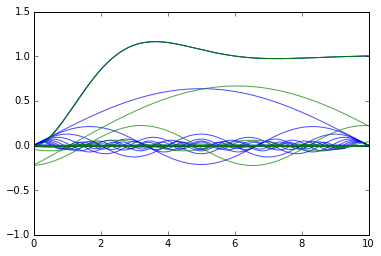

In [35]:
plt.plot(tt, gtvalues)
plt.plot(tt, sines.T, color='blue', alpha=0.7)
plt.plot(tt, shiftedsines.T, color='green', alpha=0.7)
plt.plot(tt, sum(shiftedsines) + constant, color='green')
plt.xlim(0, t0 + P)